In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
from IPython.display import display, clear_output
# from utils import gp_predict, rbf, neg_gp_likelihood
from utils import *

### MC Integration

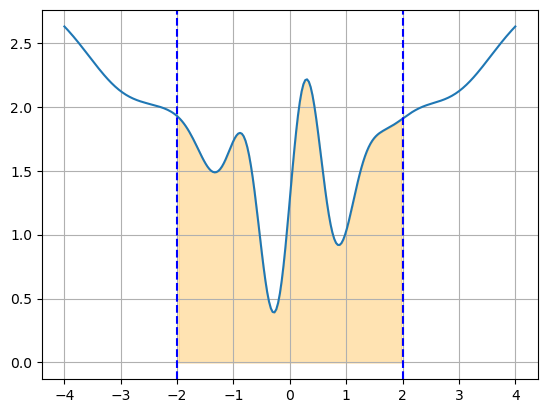

True value: 5.96051236421104

Normal Monte Carlo:
Value: 5.877926, Absolute Error: 0.082586, StDev:0.056764

Monte Carlo with Antithetic Variables:
Value: 5.974342, Absolute Error: 0.013830, StDev:0.025685


In [3]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y)
plt.axvline(lower, color='b', linestyle='--',)
plt.axvline(upper, color='b', linestyle='--',)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.grid()
plt.show()

n = 1000
true_value = 5.96051236421104

#Normal MC
x = np.random.uniform(0,1,n)
x1 = lower + x*interval
mc = jnp.mean(f(x1))*interval
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)*interval

n = 1000
#MC with Antithetic Variables
x = 1 - x
x2 = lower + x*interval
mc_at = (0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2)))*interval
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)*interval

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

### 1D Gaussian Process

A popular covariance function is the squared exponential covariance function (a.k.a. a radial-basis function or an exponential quadratic covariance function):

$$
\text{cov}(f(\mathbf{x}),f(\mathbf{x}^\prime)) = k(\mathbf{x}, \mathbf{x}^\prime) = \sigma^2\exp\left\{-\frac{1}{2l^2}\left|\mathbf{x}-\mathbf{x}^\prime\right|^2\right\}
$$

The posterior mean function is:

 - $\begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} &= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ &= K(X_*, X) K(X, X)^{-1} \mathbf{f}.
\end{aligned}$

The posterior covariance function is:
 - $\begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{f}} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ &= K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*).
\end{aligned}$

The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

Optimised params: [1.52803463 0.42529838]
Optimised log marginal likelihood: -14.019573595813903


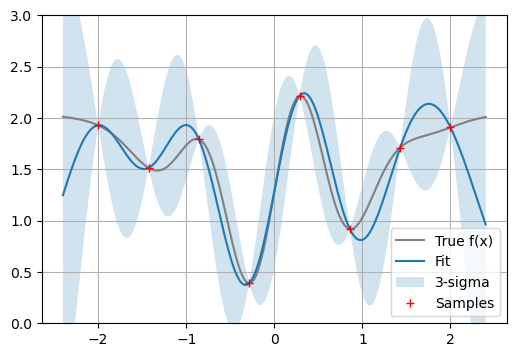

In [4]:
lower = -2
upper = 2
interval = upper - lower

# Sample points for the demonstration
n_total = 8
x_all = jnp.linspace(lower, upper, n_total)
y_all = f(x_all)

x_eval = jnp.linspace(lower-0.1*interval, upper+0.1*interval, 250)

# Start with empty dataset and add points one by one
x_data = jnp.array([])
y_data = jnp.array([])


for i in range(n_total):
    # Add next point
    x_data = jnp.append(x_data, x_all[i])
    y_data = jnp.append(y_data, y_all[i])
    
    # Re-optimize GP hyperparameters
    grad_fn = grad(neg_gp_likelihood)
    init_params = jnp.array([1.0, 1.0])
    
    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x_data, y_data, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x_data, y_data, rbf)),
        method="L-BFGS-B",
        bounds=[(1e-3, None), (1e-3, None)]
    )
    
    s, L = res.x
    
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)


    #compute GP posterior    
    mu_eval, var_eval = gp_predict(x_data, y_data, x_eval, kernel=rbf, s=s, L=L)
    sig_diag = jnp.sqrt(jnp.clip(jnp.diag(var_eval), 0.0, None))
    
    #real curve
    plt.figure(figsize=(6,4))
    plt.plot(x_eval, f(x_eval), color='gray', label='True f(x)')

    #fit
    plt.plot(x_eval, mu_eval, label='Fit')
    plt.fill_between(x_eval, mu_eval-2*sig_diag, mu_eval+2*sig_diag, alpha=0.2, label='3-sigma')
    plt.plot(x_data, y_data, '+', color='red', label='Samples')
    
    plt.ylim(0,3)
    plt.grid()
    plt.legend()
    
    display(plt.gcf())
    time.sleep(0.5)
    clear_output(wait=True)
    plt.close()

### 2D Gaussian Process

Relative Humidity is a function of temperature and dew point.

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right) \\

e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right) \\
$$
$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [4]:
def RH(T, Td):
    eT = 6.1121*jnp.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*jnp.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT

The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

Optimised params: [147.71470648  20.67886513  22.57225989]
Optimised log marginal likelihood: -73.10382822506726
For Temp: 23.3°C and DewP: -1.3°C
--------------------------------------
Relative humidity1 is: 19.4671%
The gp estimate is: 19.0144%
Error: 0.4527
95% CI: [17.9353%, 20.0936%]



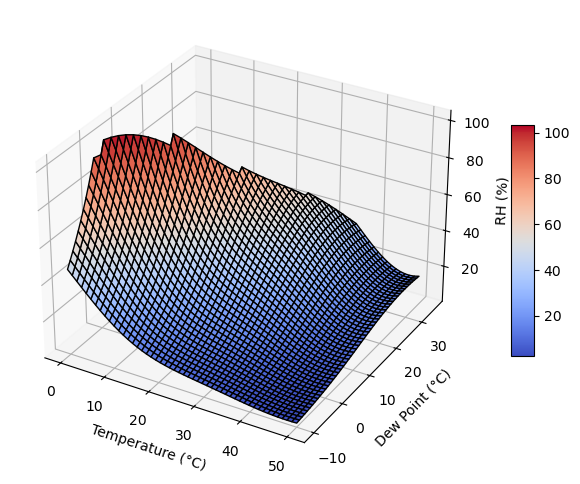

In [5]:
#training data points
Temp = jnp.linspace(0,50,5)
DewP = jnp.linspace(-10,5,4)
T, D = jnp.meshgrid(Temp, DewP)
TD = jnp.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])


#evaluation points
Temp_eval = jnp.linspace(0,50,50)
DewP_eval = jnp.linspace(-10,35,50)
T_eval, D_eval = jnp.meshgrid(Temp_eval, DewP_eval)
TD_eval = jnp.column_stack([T_eval.ravel(), D_eval.ravel()])


grad_fn = grad(neg_gp_likelihood)
s_init = 5.0
#diagonal L
l_init = jnp.array([7.0, 7.0])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, TD, rh, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, TD, rh, rbf)),
    method="L-BFGS-B",
    bounds=[(1e-3, None)] * len(init_params)
)

print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)



#fit GP
s = res.x[0]
L = jnp.diag(res.x[1:])



mu_grid, var_grid = gp_predict(TD, rh, TD_eval, kernel=rbf, s=s, L=L)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, jnp.nan, mu_grid)


#calculate relative humidity at random point
T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
td_eval = jnp.array([[T, D]])
relhum = RH(T,D)


#predict at same random point
gp_est, gp_var = gp_predict(TD, rh, td_eval, kernel=rbf, s=s, L=L)
low = gp_est - 1.96*jnp.sqrt(gp_var)
high = gp_est + 1.96*jnp.sqrt(gp_var)
error = np.abs(relhum - gp_est)


print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('--------------------------------------')
print(f'Relative humidity1 is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

#plot of GP surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


#### Integrating f(t)p(t) - univariate case

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$



where $$\textbf{k}_F(x) = \Big[ \int k(t, x_1)p(t)dt,\, \int k(t, x_2)p(t)dt,\, \cdots ,\, \int k(t, x_n)p(t)dt \Big]$$,
$$K(x'x) = \int \int k(t, s)p(t)p(s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [6]:
def vk(input,sigma,L,mu_p,s_p):
    t1 = jnp.sqrt(L**2/(L**2 + s_p**2))
    t2 = jnp.exp(-(input-mu_p)**2/(2*(L**2 + s_p**2)))
    return sigma**2*t1*t2

def vvk(sigma,L,s_q):
    t1 = jnp.sqrt(L**2/(L**2 + 2*s_q**2))
    return sigma**2*jnp.sqrt(L**2/(L**2 + 2*s_q**2))

def integrate_gaussian(x_eval, y_eval, sigma, L, mu_p, s_p):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbf(x_eval, x_eval, s, L)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF = vk(x_eval, sigma, L, mu_p, s_p).reshape(-1,1)
    vF = vvk(sigma, L, s_p)
    
    #posterior mean and variance
    mu = (kF.T@jnp.linalg.solve(Kxx, y_eval)).item()
    var = vF - (kF.T@jnp.linalg.solve(Kxx, kF)).item()
    var = jnp.maximum(var, 0.0)
    
    return mu, var[0][0]

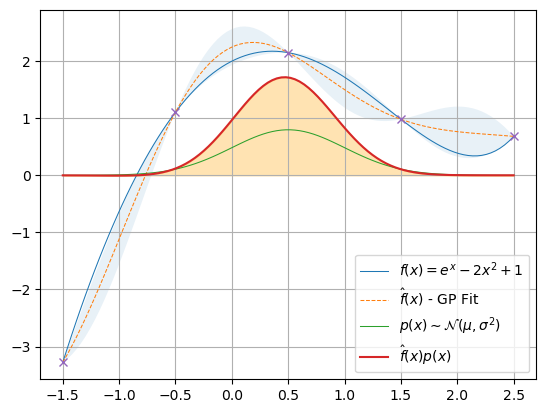

Eₚ[f(x)]: 1.8682459574322223

Bayesian Quadrature
1 pts:
Optimised params: [1.10653015 0.5       ]
Optimised log marginal likelihood: -1.5201681220623735
Estimate: 0.28784187 , StDev: 0.78997467
Absolute Error: 1.58040408

4 pts:
Optimised params: [1.32566629 1.12996312]
Optimised log marginal likelihood: -4.059963713457724
Estimate: 1.87116879 , StDev: 0.00157505
Absolute Error: 0.00292284

8 pts:
Optimised params: [2.8244946  1.40270729]
Optimised log marginal likelihood: 10.054355556565309
Estimate: 1.86820136 , StDev: 0.00006591
Absolute Error: 0.00004460

16 pts:
Optimised params: [3.52479664 1.52500503]
Optimised log marginal likelihood: 55.78181437235306
Estimate: 1.86820909 , StDev: 0.00002788
Absolute Error: 0.00003686

32 pts:
Optimised params: [3.8816996  1.58285823]
Optimised log marginal likelihood: 149.62179042764234
Estimate: 1.86821287 , StDev: 0.00002131
Absolute Error: 0.00003309



In [7]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 0.5
sigma = 0.5
true_value = FP(mu,sigma)


#sample n points
n = 5
x = jnp.linspace(mu-4*sigma,mu+4*sigma,n)
y = f(x)

grad_fn = grad(neg_gp_likelihood)
s_init = 1
#diagonal L
l_init = jnp.array([1])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
    method="L-BFGS-B",
    bounds=[(1e-3, None)] * len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])

#points to plot gp
x_eval = np.linspace(mu-4*sigma,mu+4*sigma,100)
mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))

#real curve
y1 = f(x_eval)
y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
y3 = fp(x_eval,mu,sigma)


mask = (x_eval >= mu-4*sigma) & (x_eval <= mu+4*sigma)
points_fill = x_eval[mask]
y_fill = y3[mask]

#plot gp
plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
plt.plot(x,y,'x')
plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.legend()
plt.grid()
plt.show()


print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,4,8,16,32]:

    x = np.linspace(mu-2*sigma,mu+2*sigma,n)
    y = f(x)

    grad_fn = grad(neg_gp_likelihood)
    s_init = 0.5
    #diagonal L
    l_init = jnp.array([0.5])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds = [(1e-3, None)]*len(init_params)

    )


    #kernel hyperparameters
    s = res.x[0]
    L = jnp.diag(res.x[1:])


    I_mu, I_var = integrate_gaussian(x,y,s,L,mu,sigma)
    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()